# Research Bandits (correlation clusters)

- This notebook analyses porfolio performance of 24 stocks from 2013 to 2023.
- The 24 stocks are selected dynamically every two weeks w.r.t to a group of clusters.
- The clusters are recreated every year w.r.t the 120 more performing stocks from the previous year.

Note : In this notebook we consider 20 simulations per year in the bandit selection criteria

In [18]:
import os
import sys
path = '/'.join(os.path.abspath('').split('/')[0:-2])
print(path)
sys.path.append(path)

import pickle
import pandas as pd
import json
import random, tqdm
import numpy as np

from experts.alpha import alpha
from exploration.explore import explore
from exploration.outils import stats

import plotly.express as px

/home/mora/Documents/projects/Bandits


In [19]:
N_SIMS = 20

In [20]:
with open('../../../datasharing/tickers.json','r') as file:
    tickers = json.load(file)

tickers = tickers["sp500"]

In [21]:
# Load the pickle file that contains the full data for each stock
with open('../../../datasharing/hist_stock_data.pkl','rb') as file:
    df_hst_tickers = pickle.load(file)

# Chose the label "Close" as the main label to analyse the price series
label = 'Close'
df_close_stocks = pd.DataFrame([])
for key, df in df_hst_tickers.items():
    df_close_stocks = pd.concat([df_close_stocks,
                                 df[label]], axis = 1)

# Create a single data frame that cotains the series data from all the SP500 stocks
df_close_stocks.columns = list(df_hst_tickers.keys())
df_close_stocks['date'] = df_close_stocks.index
df_close_stocks.index = pd.to_datetime(df_close_stocks['date'])


df_close_stocks = pd.DataFrame()

for ticker in tickers:
    srs = df_hst_tickers[ticker][['Close']]
    srs.columns = [ticker]
    df_close_stocks = pd.concat([df_close_stocks,srs], axis = 1)
    
df_close_stocks.reset_index(inplace = True)
df_close_stocks['date'] = pd.to_datetime(df_close_stocks['Date'])

# Resample series in terms of 2Weeks
df_close_stocks.set_index('date', inplace = True)
df_2w = df_close_stocks.resample("2W").last()

In [22]:
# Creating the function that compute the statistics
def get_stats(df_close_stocks, tickers: dict, years: list = None,
              inter = None, freq:str = 'M', min_els:int = 6) -> dict:
    """
    This function produces some statistics using a dataframe fille with stocks.
    Precisely the average mean return and the sharpe ratio.
    Args:
        df_hst_tickers (dict) - contains dataframes for multiple stocks
        tickers (list) - the list of tickers to compute the statistics 
        years (list) - the list of years to compute the statistics
        inter (slice) - A slice that precises the data indexs to compute the statistics
        freq (str) - the frequency for the statistics (Y,M,W,2W, ...)
        min_els(int) - the minimum quantity of elements in the series required
            after the frequency postprocessing.
    """
    st_stats = {}
    for ticker in tickers:
        if years:
            tmp_df = df_close_stocks[df_close_stocks['Date'].dt.year.isin(years)]
        elif inter:
            tmp_df = df_close_stocks.iloc[inter]

        pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()

        # discart ticket if not enough data
        if pc_m.shape[0] < min_els:
            continue
            
        av_ret = pc_m.mean()
        sr = av_ret / pc_m.std()
        st_stats[ticker] = {"sr":sr, 'av_ret':av_ret}
            
    return st_stats

def df_and_sort(st_stats: dict, col: str) -> pd.DataFrame :
    """
    Function that creates a dataframe using a dictionary of stocks with statistics
    metrics and sort the dataframe based on the column name precised.
    Args:
        st_stats (dict) - The dictionary containing the statistics.
        col (str) - The name of the column for sorting.
    """
    df_stats = pd.DataFrame(st_stats).transpose()
    df_stats.sort_values(by=col, inplace = True, ascending = False)
    return df_stats


def create_stock_groups(lst_stocks: list, basket_size: int,
                        max_stocks: int):
    """
    Create multiple group of stocks with basket_size elements
    inside each group.
    Args:
        lst_stocks (list) : List of stocks
        basket_size (int): The total element of stocks in
            each basket.
    """
    
    random.shuffle(lst_stocks)
    stcks = {'stocks_dict':list(lst_stocks), 'groups':{}}

    for i in range(0,max_stocks,basket_size):
        stcks['groups'].update({i:list(tst[i:i+basket_size])})
    
    return stcks


def create_anticorr_group_stocks(tst, df_close_stocks, year):
    df_corr = df_close_stocks[df_close_stocks['Date'].dt.year == year][tst].corr().abs()
    groups_stocks = []
    while df_corr.shape[0]:
        stock = df_corr.index[0]
        new_stock = df_corr[stock].sort_values().index[0]
        thr_stock = df_corr.loc[[stock, new_stock]].sum().sort_values().index[0]
        four_stock = df_corr.loc[[stock, new_stock, thr_stock]].sum().sort_values().index[0]
        lst_stocks = [stock, new_stock,thr_stock, four_stock]
        groups_stocks.append(lst_stocks)
        df_corr = df_corr.drop(columns = lst_stocks, index = lst_stocks)
    return groups_stocks

def simulate_year(df_series, years: list, n_sims: int,
                  stock_groups: dict, exploration_rate: float,
                  p_alpha: float):

    df_test = df_series[df_series['Date'].dt.year.isin(years)]
    lines = []

    for lst_stocks in stock_groups:

        df_bandits = df_test[lst_stocks].pct_change(1).dropna()

        if df_bandits.shape[0] == 0:
            continue

        arguments = {"exploration_rate": exploration_rate,
                     "n_bandit":df_bandits.shape[1],
                     "steps":df_bandits.shape[0],
                     "alpha":p_alpha,
                     "df_bandits":df_bandits
                    }


        exp = explore(alpha.execute)
        exp.execute(n_sims, **arguments)
        mean, std = stats(exp.rets_compo)
        line = [arguments["alpha"],
                arguments["exploration_rate"],
                mean,
                std]

        lines.append(line)

    df_rets = pd.DataFrame(lines)
    df_rets.columns = ["alpha", "expl", "mean", "std"]
    
    return df_rets.mean()

In [23]:
# Create a group of stocks
max_stocks = 120
stock_groups = {}
metric = 'sr' # choose between 'av_ret' or 'sr'

for year in tqdm.tqdm(range(2012,2024)):

    years_tr = list(range(year - 10, year))
    stats_tr = get_stats(df_close_stocks, tickers, years = years_tr)
    df_stats_tr = df_and_sort(stats_tr, metric)
    tst = df_stats_tr.index[0:max_stocks].values
    #stock_groups[year] = create_stock_groups(tst,basket_size,max_stocks)
    stock_groups[year] = create_anticorr_group_stocks(tst, df_close_stocks, year-1)

  0%|                                                    | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling p

/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[t

/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[t

/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[t

 17%|███████▎                                    | 2/12 [00:03<00:15,  1.55s/it]/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling p

/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[t

/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[t

/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[t

/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[t

/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[t

/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_73360/478011675.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[t

In [24]:
N_SIMS = 2
final_stats = []

for year in tqdm.tqdm(range(2012,2024)):
    for exploration_rate in np.arange(0.01,0.15,0.01):
        for p_alpha in np.arange(0.005,0.15,0.005):
            st_year = simulate_year(df_2w, [year], n_sims = N_SIMS,
                                    stock_groups = stock_groups[year],
                                    exploration_rate = exploration_rate,
                                    p_alpha = p_alpha
                                   )
            tmp_year = {"year":year,"ex_rate":exploration_rate,
                        "alpha":p_alpha, "return": st_year['mean']}
            final_stats.append(tmp_year)

100%|███████████████████████████████████████████| 12/12 [07:14<00:00, 36.22s/it]


In [25]:
df_res = pd.DataFrame(final_stats)
df_groups = df_res.groupby(by=['ex_rate','alpha']).mean()['return'].reset_index()

In [26]:
dict_perf = {}
for year in range(2012,2023):
    vals = df_res[df_res['year']==year].sort_values(by = 'return').iloc[-1].to_dict()
    dict_perf[year] = vals

In [27]:
dict_perf_nxt_y = {}
for year in range(2012,2023):
    alpha = dict_perf[year]['alpha']
    ex_rate = dict_perf[year]['ex_rate']
    perf_nxt = df_res[(df_res['year'] == year + 1 ) &\
               (df_res['alpha'] == alpha) &\
               (df_res['ex_rate'] == ex_rate)].iloc[0].to_dict()
    dict_perf_nxt_y[year+1] = perf_nxt

In [28]:
dict_perf_nxt_y

{2013: {'year': 2013.0,
  'ex_rate': 0.09,
  'alpha': 0.1,
  'return': 0.3164768254549518},
 2014: {'year': 2014.0,
  'ex_rate': 0.08,
  'alpha': 0.065,
  'return': 0.21808120553057064},
 2015: {'year': 2015.0,
  'ex_rate': 0.09999999999999999,
  'alpha': 0.135,
  'return': 0.05858891857559552},
 2016: {'year': 2016.0,
  'ex_rate': 0.11,
  'alpha': 0.135,
  'return': 0.17158233242407847},
 2017: {'year': 2017.0,
  'ex_rate': 0.13,
  'alpha': 0.005,
  'return': 0.1902308223257812},
 2018: {'year': 2018.0,
  'ex_rate': 0.14,
  'alpha': 0.09000000000000001,
  'return': -0.030411003477896496},
 2019: {'year': 2019.0,
  'ex_rate': 0.09,
  'alpha': 0.115,
  'return': 0.35911180753250116},
 2020: {'year': 2020.0,
  'ex_rate': 0.12,
  'alpha': 0.13,
  'return': 0.2794617757824608},
 2021: {'year': 2021.0,
  'ex_rate': 0.09999999999999999,
  'alpha': 0.005,
  'return': 0.3143188601175551},
 2022: {'year': 2022.0,
  'ex_rate': 0.01,
  'alpha': 0.14500000000000002,
  'return': -0.1358693339926510

In [29]:
perf = pd.DataFrame(dict_perf_nxt_y).T

In [30]:
(perf[0:]['return'] + 1).cumprod()

2013    1.316477
2014    1.603576
2015    1.697527
2016    1.988793
2017    2.367123
2018    2.295136
2019    3.119347
2020    3.991085
2021    5.245558
2022    4.532848
2023    5.638960
Name: return, dtype: float64

In [31]:
com_ret = (perf['return'] + 1).cumprod()
com_ret_last = com_ret.iloc[-1]

<AxesSubplot: >

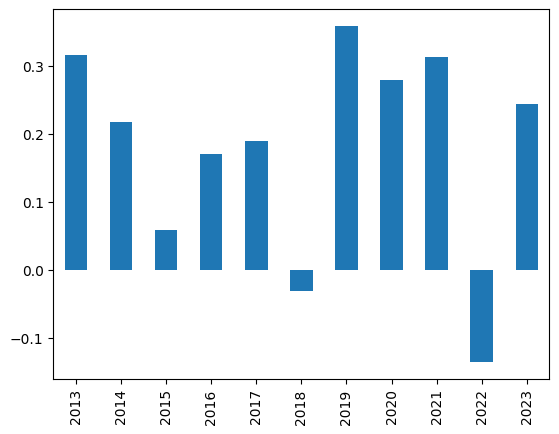

In [32]:
perf['return'].plot.bar()

In [33]:
N = 11 # number of years (2013 - 2023)
av_a_ret = (com_ret_last)**(1/N)

print("Return final year ", com_ret_last)
print("Average annual return ", av_a_ret)

Return final year  5.638959899017574
Average annual return  1.1702827908917548
